In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time
# from keras.callbacks import Callback, TensorBoard, EarlyStopping, ModelCheckpoint
from convnet_sigma_err import *
# from keras.utils import plot_model
import random
from data_generator_sigma_err import *
from keras.metrics import top_k_categorical_accuracy
from sklearn.metrics import accuracy_score
import numpy.ma as ma
import matplotlib as mpl
import seaborn as sns
from plotting import results_categorical_histo #plot_emiss_signal, data_err_histo, 
# from gp_real_data import compute_abs_error
import time
# from postprocess import post_training
from matplotlib.backends.backend_pdf import PdfPages

 
def main(args):
    exp_id = './exps/' + args[1]
    train_dir = './exps/' + args[1]
    if not os.path.isdir(train_dir):
        os.makedirs(train_dir)
    print('Will save this model to', train_dir)
    
    checkpoint_dir = train_dir +'/model_checkpoints/'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        
    logs_dir = train_dir +'/logs/'
    if not os.path.isdir(logs_dir):
        os.makedirs(logs_dir)
        
    hp_dic = load_dic(exp_id + '/hp_params')
    sigma_fs = hp_dic['sigma_fs']
    sigma_xs = hp_dic['sigma_xs']
    sigma_errs = hp_dic['sigma_errs']   
        
    epoch_size = 128 #128
    no_epocs = 5
    no_sensors = hp_dic['measurement_dim']
    # print(no_sensors)
    # exit(0)
    num_classes = len(sigma_fs)*len(sigma_xs)*len(sigma_errs)
    bsize = num_classes*8 #/32/ samples per hyperparameter
    
    ensemble_size = 2
    
    def top_2_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=2)
    
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)
    # -------- Training --------
    params_random = {'dim': no_sensors,
                      'no_batches_ep': epoch_size, 
                      'shuffle': True,
                      'exp_id': exp_id,
                      'batch_size': bsize,
                      'epoch_size':epoch_size,
                      # 'shots': train_val_shots,
                      'n_splits':ensemble_size
                      }
    
    print('experiment parameters', params_random)
    
    mainGenerator = DataGenerator(**params_random)
    
    ensemble = []
    pred_hps_top_all = []
    scores_matrix = {'train':np.empty((ensemble_size, len(sigma_fs)*len(sigma_errs)*len(sigma_xs))),
                     'test':np.empty((ensemble_size, len(sigma_fs)*len(sigma_errs)*len(sigma_xs)))}
    val_ms = []
    val_errs = []
    used_ms_all = []
    st_all = []
    # pred_deltas = []
    
    for k_fold in range(mainGenerator.n_splits):
        print('----------------------------------------------Training member', k_fold+1, 'of ensemble...----------------------------------------------')
        cnn = model(no_sensors, len(sigma_fs), len(sigma_xs), len(sigma_errs), k_fold)
    
    
        cnn.compile(loss={'single_mclass':'categorical_crossentropy'},
                    optimizer='adam',
                    metrics={'single_mclass':['categorical_accuracy', top_2_accuracy, top_3_accuracy]})
        
        train_generator = TrainDataGenerator(k_fold, mainGenerator)
        train_gen = next(iter(train_generator))
        val_generator = ValDataGenerator(k_fold, mainGenerator)
        val_gen = next(iter(val_generator))
        # mainGenerator.get_stats(), train_generator.get_stats(), val_generator.get_stats()
        # exit(0)
        train_start = time.time()
        cnn.fit_generator(generator = train_gen, steps_per_epoch=epoch_size, epochs=no_epocs, validation_data=val_gen, validation_steps=epoch_size)#, callbacks=[saveCheckpoint,]) #,tb ,, validation_steps=bsize
        train_end = time.time()
        print('----------------------------------------------')
        print('training took:', train_end-train_start, 'seconds')
        print('----------------------------------------------')
    
        scores = get_scores(train_generator, cnn, num_classes)
        scores_matrix[str(train_generator)][k_fold] = np.asarray(scores)
    
        scores = get_scores(val_generator, cnn, num_classes)
        scores_matrix[str(val_generator)][k_fold] = np.asarray(scores)
        
        
    # exit(0)
    # print('----------------------------------------------')
    # print('average fraction of used measurements per data point:', np.mean(used_ms_all))
    # print('----------------------------------------------')
    # print('time the classifiers took to predict across their k-fold split:', np.asarray(pred_deltas))
    # print('average time the classifiers took to predict across their k-fold split:', np.mean(pred_deltas))
    # print('total time the classifiers took to predict across the entire k-fold split:', np.sum(pred_deltas))
    # print('----------------------------------------------')
    
    np.save(exp_id + '/scores_matrix_val', scores_matrix[str(val_generator)])
    np.save(exp_id + '/scores_matrix_train', scores_matrix[str(train_generator)])
    # print(scores_matrix[str(val_generator)])
    # print(scores_matrix[str(val_generator)].shape)
    # print(np.mean(scores_matrix[str(val_generator)], axis=0))
    # print(np.var(scores_matrix[str(val_generator)], axis=0))
    pdf_handler = PdfPages(exp_id + '/accuracy_histogram_val.pdf')
    results_categorical_histo(pdf_handler, scores_matrix[str(val_generator)])
    pdf_handler = PdfPages(exp_id + '/accuracy_histogram_train.pdf')
    results_categorical_histo(pdf_handler, scores_matrix[str(train_generator)])

def get_scores(generator, cnn, num_classes):
    inputs, targets = generator.get_all_items()
    measurements = inputs
    labels = targets#[:10]
    labels_argmax = np.argmax(labels, axis=1)
    
    print('classifier predicting on its val data, whose shape is', measurements.shape, labels.shape)#, train_val_hps[:100].shape) errs.shape,  labels_argmax.shape
    # pred_start = time.time()
    pred_hps = cnn.predict(measurements)
    # pred_end = time.time()
    # pred_delta = pred_end-pred_start
    # print('----------------------------------------------')
    # print('prediction took:', pred_delta, 'seconds')
    # pred_deltas.append(pred_delta)
    # print('----------------------------------------------')
    
    argsort_preds = np.argsort(pred_hps, axis=1)
    # pred_hps_top_all.extend(argsort_preds[:, -1])
    print('shape of predictions of whole dataset, ', pred_hps.shape)
    acc_sum = 0
    acc_list = []
    acc_h = []
    for k in range(num_classes):
        acc_int = accuracy_score(labels_argmax, argsort_preds[:,-1-k], normalize=False)
        acc_sum += acc_int
        acc_h.append(acc_sum/len(labels_argmax))
        acc_list.extend(np.ones(acc_sum) * k)
    return acc_h


Will save this model to ./exps/exp5
experiment parameters {'dim': 136, 'no_batches_ep': 128, 'shuffle': True, 'exp_id': './exps/exp5', 'batch_size': 144, 'epoch_size': 128, 'n_splits': 2}


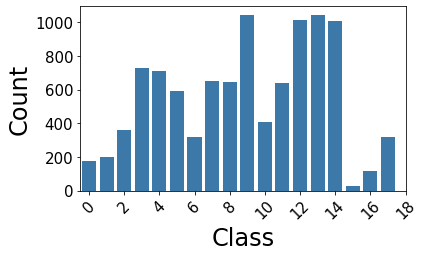

Got 10000  data  samples. Hyperparameters were: f-> [ 10  75 250] x [0.125 0.175 0.225] err [0.5 1. ]
------------------Printing stats for main generator------------------
f,x,err,count
0-0-0 174
0-0-1 1043
0-1-0 201
0-1-1 407
0-2-0 363
0-2-1 639
1-0-0 728
1-0-1 1015
1-1-0 710
1-1-1 1043
1-2-0 593
1-2-1 1010
2-0-0 318
2-0-1 28
2-1-0 649
2-1-1 115
2-2-0 644
2-2-1 320
Total number of samples: 10000
----------------------------------------------Training member 1 of ensemble...----------------------------------------------
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m (InputLayer)               [(None, 136, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 136, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 136, 32)           31

----------------------------------------------
training took: 341.1105606555939 seconds
----------------------------------------------
classifier predicting on its val data, whose shape is (5005, 136, 1) (5005, 18)
shape of predictions of whole dataset,  (5005, 18)
classifier predicting on its val data, whose shape is (4995, 136, 1) (4995, 18)
shape of predictions of whole dataset,  (4995, 18)


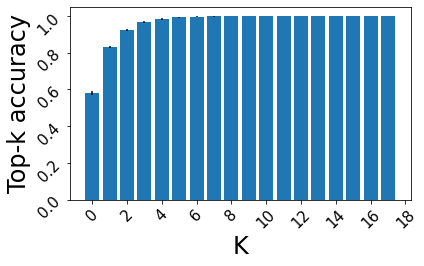

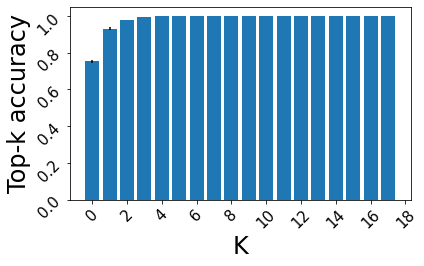

In [2]:
main(['', 'exp5'])